# Visualize Predictions

## Parameters

In [68]:
import yaml
from piosfinder.train import create_dataloader, load_model       # NOTE: since we're using these functions across files, it could make sense to put them in e.g. a "util.py" script.
from piosfinder.model import ResNet, ResidualBlock
import torch

from torchvision.utils import save_image, make_grid
import matplotlib.image as mpimg
from  matplotlib import pyplot as plt
import numpy as np
import torchvision
from torchvision.io import read_image
from mpl_toolkits.axes_grid1 import ImageGrid

from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

In [7]:
config = 'model_states/config.yaml'
split = 'test'

In [8]:
config

'model_states/config.yaml'

In [11]:
cd ..

/home/rache/code/piosfinder


## Load Data

In [59]:
# load config
print(f'Using config "{config}"')
cfg = yaml.safe_load(open(config, 'r'))


# setup entities
dl = create_dataloader(cfg, split='val')

# State dict
# sd = torch.load("model_states/8.pt")['model']

# load model
model = ResNet(ResidualBlock, [3, 4, 6, 3])
model.load_state_dict(torch.load('model_states/29.pt')['model'])
# model.eval() # enabling the eval mode to test with new samples.

Using config "model_states/config.yaml"
Total images:
271


<All keys matched successfully>

## Visualize

In [57]:
# Load some data
data, labels = next(iter(dl))

# Put model on device (?)
device = cfg['device']
model.to(device)

# Evaluate model (?)
model.eval()

# Predict
prediction = model(data)

# Convert to predictions:
preds = prediction.argmax(dim=1)

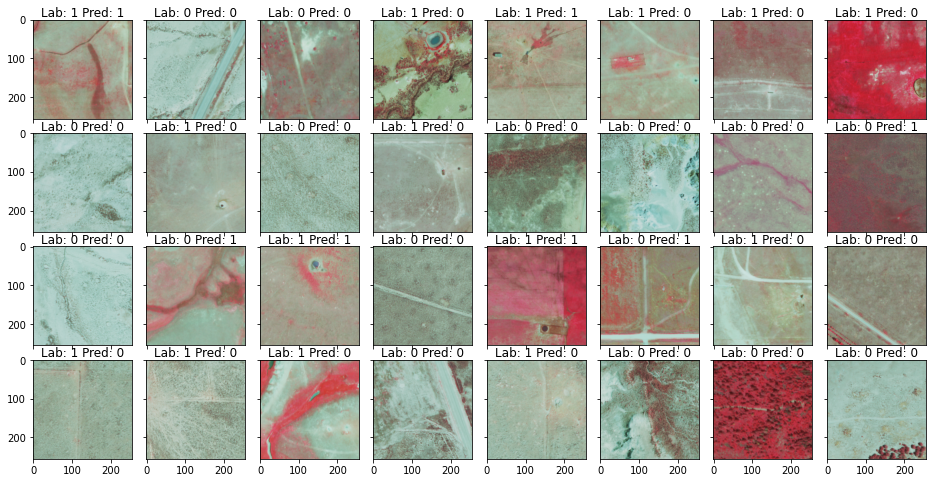

In [58]:
# Make nice figures:
fig = plt.figure(figsize=(16., 32.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(4, 8),  # creates 2x2 grid of axes
                 axes_pad=0.2,  # pad between axes in inch.
                 )

for ax, im, lb, pred in zip(grid, data, labels, preds):
    im = torchvision.transforms.ToPILImage()(im)
    # pred = pred.detach().numpy()
    # Iterating over the grid returns the Axes.
    ax.set_title("Lab: "+ str(np.array(lb)) + " Pred: " + str(pred.item()), pad = 3)
    ax.imshow(im)

plt.show()

## Visualize errors

In [85]:
false_positives = []
false_negatives = []
true_positives = []
for idx, (data, labels) in enumerate(dl_test):  
    truelabs.append(labels)

    # Evaluate model (?)
    model.eval()

    # Predict
    prediction = model(data)

    # Convert to predictions:
    preds = prediction.argmax(dim=1)

    # Pull out false negs and positives
    for lb, pred, img in zip(labels, preds, data):
        if lb == 1 and pred == 1:
            true_positives.append(img)
        elif lb == 0 and pred == 1:
            false_positives.append(img)
        elif lb == 1 and pred == 0:
            false_negatives.append(img)
        else:
            continue

In [97]:
len(false_positives)

40

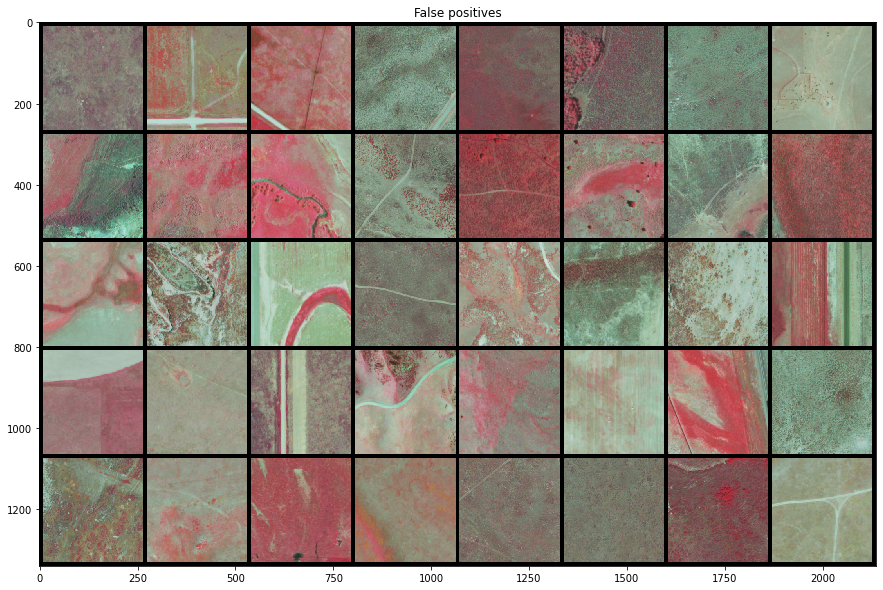

In [83]:
def show(img):
    npimg = img.numpy()
    
    plt.figure(figsize = (15,10))
    plt.title("False positives")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect = 'auto')

grid = torchvision.utils.make_grid(false_positives, nrow=8, padding=10)
show(grid)

In [98]:
len(false_negatives)

36

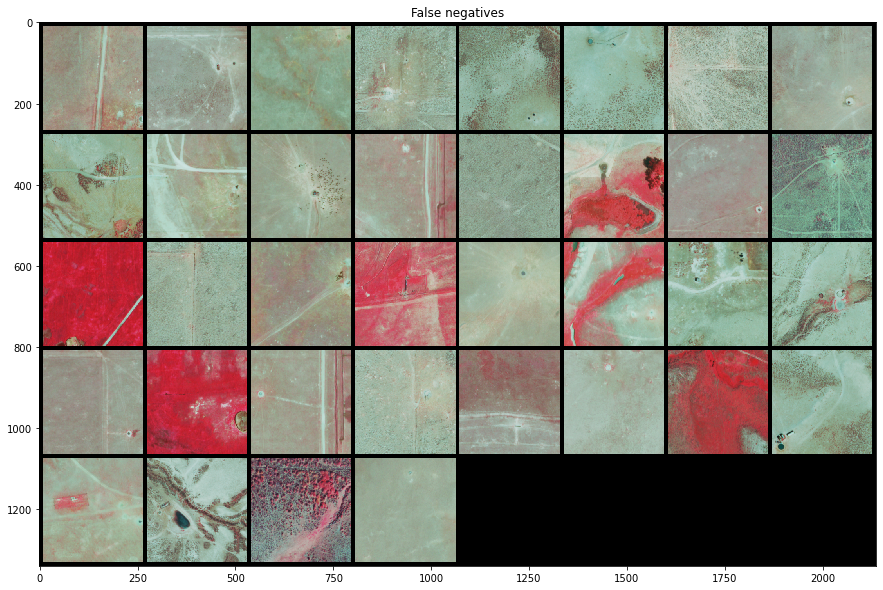

In [84]:
def show(img):
    npimg = img.numpy()
    
    plt.figure(figsize = (15,10))
    plt.title("False negatives")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect = 'auto')

grid = torchvision.utils.make_grid(false_negatives, nrow=8, padding=10)
show(grid)

In [87]:
len(true_positives)

32

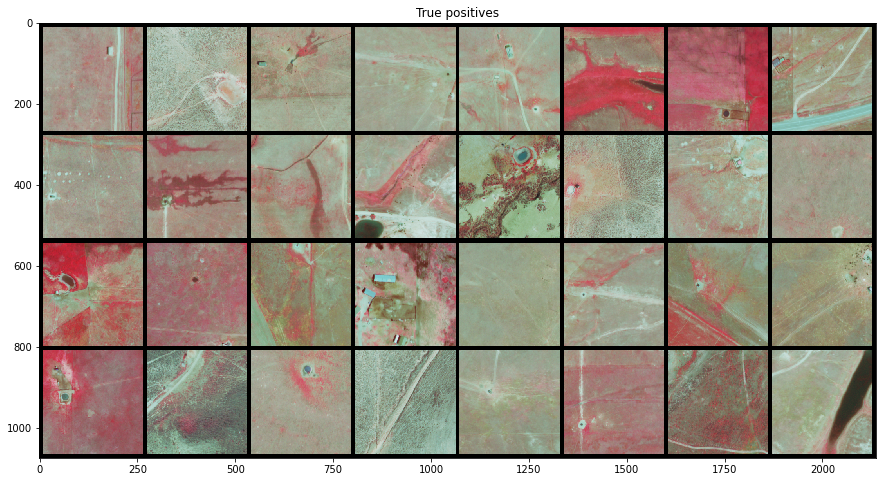

In [96]:
def show(img):
    npimg = img.numpy()
    
    plt.figure(figsize = (15,8))
    plt.title("True positives")
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest', aspect = 'auto')

grid = torchvision.utils.make_grid(true_positives, nrow=8, padding=10)
show(grid)

## Make confusion matrix for Validation Dataset

In [61]:
nb_classes = 2

confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)

tensor([[161.,  42.],
        [ 37.,  31.]])


In [101]:
nb_classes = 2

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dl):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[163  40]
 [ 36  32]]
[80.2955665  47.05882353]


Text(0.5, 15.0, 'Predicted label')

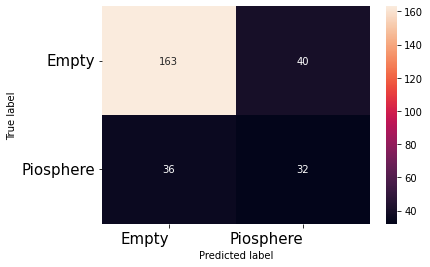

In [102]:
class_names = ['Empty','Piosphere']
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')